In [4]:
import pandas as pd 
import ast 
import numpy as np 
import os 
from pathlib import Path
import re

In [5]:
# douma 
os.chdir(Path(os.getcwd()).parent)

In [6]:
# Internal import 
from helpers import *

### 1. Population

In [7]:
df = pd.read_csv('data/lsoa-data-old-boundaries-DataSheet.csv', encoding = "ISO-8859-1")

C:\Users\PC\AppData\Local\Temp\ipykernel_15940\92757048.py:1: DtypeWarning: Columns (757,758,760,761,762,844,845,851,852,853,868,874,875,880,881,886,887,892,893,900,901,916,917,924,925,932,933,949,950,958,959,974,975,994,995,1000,1001,1010,1011,1020,1021,1080) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/lsoa-data-old-boundaries-DataSheet.csv', encoding = "ISO-8859-1")


In [8]:
# Population 
df = pd.read_csv('data/lsoa-data-old-boundaries-DataSheet.csv', encoding = "ISO-8859-1")
col = ['Lower Super Output Area', 'Names', 'Mid-year Population Estimates;Aged 0-15;2012'] # Subset 
df = df[col].dropna(subset=['Lower Super Output Area']).copy()
df.columns = ['LSOA code', 'names', 'pop_2012'] # Rename 
# Types 
df['names'].astype(str)
df['LSOA code'].astype(str)
df['pop_2012'].astype(float);
df = df[df['names'].apply(lambda row: 'Barnet' in row)] # Barnet only

C:\Users\PC\AppData\Local\Temp\ipykernel_15940\1643310958.py:2: DtypeWarning: Columns (757,758,760,761,762,844,845,851,852,853,868,874,875,880,881,886,887,892,893,900,901,916,917,924,925,932,933,949,950,958,959,974,975,994,995,1000,1001,1010,1011,1020,1021,1080) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/lsoa-data-old-boundaries-DataSheet.csv', encoding = "ISO-8859-1")


In [9]:
# Mapping to wards 
pop_df = mapping_wards(df)
pop_df.dropna(inplace=True)

In [10]:
# Total 
pop_df = pop_df[['WD22NM', 'pop_2012']].groupby('WD22NM').sum().reset_index()
pop_df.rename(columns={'WD22NM' : 'Ward'}, inplace=True)

### 2. Crime prediction 

In [11]:
# Read-in:
predicted_df = pd.read_csv('data/total_crime_predicted.csv')
predicted_df.drop(columns=['Unnamed: 0'], inplace=True)
predicted_f1 = predicted_df.iloc[0] # Only first month 
predicted_f1.index = pop_df.Ward.values
crime_df = pd.DataFrame({
    'Ward' : predicted_f1.index,
    'predicted_crime' : predicted_f1.values
})
crime_df;


In [9]:
crime_df;

### 3. CCTV

https://open.barnet.gov.uk/dataset/2l0g2/cctv-camera-locations
This dataset incorporates CCTV cameras installed by London Borough of Barnet in conjunction with OCS Ltd for the purposes of Community Safety.

In [10]:
postcode = pd.read_csv('data/CCTV/Barnet postcodes.csv')
# postcode.head()

In [11]:
# Read-in PostCode:
postcode = pd.read_csv('data/CCTV/Barnet postcodes.csv')
postcode = postcode[['Postcode', 'Ward']].copy()
postcode['Postcode'] = postcode['Postcode'].apply(lambda row: row[:3])
postcode.drop_duplicates(inplace=True)
postcode['Postcode'] = postcode['Postcode'].astype(str)

In [12]:
# Read-in CCTV:
cam_df = pd.read_csv('data/CCTV/2017-06-12 CCTV camera list.csv', encoding = "ISO-8859-1")
cam_df['Zone'] = cam_df['Zone'].astype(str).apply(lambda row: row[-3:])
cam_df.drop(columns=['Location'], inplace=True)
cam_df.rename(columns={'Zone' : 'Postcode'}, inplace=True)
cam_df['Postcode'] = cam_df['Postcode'].astype(str)

In [13]:
# Map to wards
cctv_df = cam_df.merge(postcode, how='cross')
cctv_df = cctv_df[cctv_df.Postcode_x == cctv_df.Postcode_y][['Camera', 'Ward']]
cctv_df = cctv_df.groupby('Ward').count().reset_index()
cctv_df;

In [14]:
# Add the missing 
missing = pop_df['Ward'][pop_df['Ward'].apply(lambda row: row not in cctv_df.Ward.values)]
douma = pd.DataFrame({
    'Ward' : missing,
    'Camera' : [0, 0],
})
cctv_df = pd.concat([cctv_df, douma]).sort_values(by='Ward').reset_index(drop=True)
cctv_df;

### 4. Stop-and-Search


In [15]:
# Load 
# PATH = 'data/data_sas'
# lst_df = []
# for subdir in os.listdir(PATH):
#     file_path = os.path.join(PATH, subdir)
#     for file in os.listdir(file_path):
#         file = os.path.join(file_path, file)
#         try:
#             lst_df.append(pd.read_csv(file))
#         except FileNotFoundError:
#             continue

# df_sas = pd.concat(lst_df)

This doesn't work  

### 5. English Indices of Deprivation 2019 - LSOA Level

The Indices of Deprivation are the government's official measure of multiple deprivation at small area level and provide a consistent measure of deprivation across England1. The English Indices of Deprivation measure relative deprivation in small areas in England called lower-layer super output areas (LSOAs)2. The indices are based on 39 separate indicators, organised across seven distinct domains of deprivation23. These domains are:

- a. Index of Multiple Deprivation (IMD) 
- b. Income Deprivation Domain 
- c. Employment Deprivation Domain 
- d. Education, Skills and Training Domain 
- e. Health Deprivation and Disability Domain 
- f. Crime Domain 
- g. Barriers to Housing and Services Domain 
- h. Living Environment Deprivation Domain 
- i. Income Deprivation Affecting Children Index (IDACI) 
- j. Income Deprivation Affecting Older People Index (IDAOPI) 

Three measure types: Decile, Rank, and Score

In [12]:
# Read-in:
imd_df = pd.read_csv('IMD/imd2019lsoa (1).csv').drop(columns=['DateCode', 'Units'])
imd_df.rename(columns={'FeatureCode' : 'LSOA code'}, inplace=True)
imd_df = mapping_wards(imd_df)
# Take only the IMD (weighted sum) : Score
imd_df = imd_df[imd_df['Indices of Deprivation'] == 'a. Index of Multiple Deprivation (IMD)']
imd_df = imd_df[imd_df['Measurement'] == 'Score'].copy()
imd_df.drop(columns=['LSOA code', 'Measurement', 'Indices of Deprivation'], inplace=True)
imd_df = imd_df[imd_df['WD22NM'].apply(lambda row: row in pop_df.Ward.values)] # Take only Barnet's
imd_df = imd_df.groupby('WD22NM').sum().reset_index()
imd_df = imd_df.rename(columns={'WD22NM' : 'Ward'})
imd_df;

In [13]:
# Load df_all:
df_all = pd.read_csv('data/filter/df_all.csv')
df_all = df_all.drop(columns=['Unnamed: 0'])
df_all['ts'] = pd.to_datetime(df_all.Month)
df_all['year'] = df_all.ts.apply(lambda row: row.year)

In [14]:
# Calculate the mean
mean_2019 = df_all[df_all.year == 2019].drop(columns=['Month', 'ts', 'year']).mean()
mean_2019;

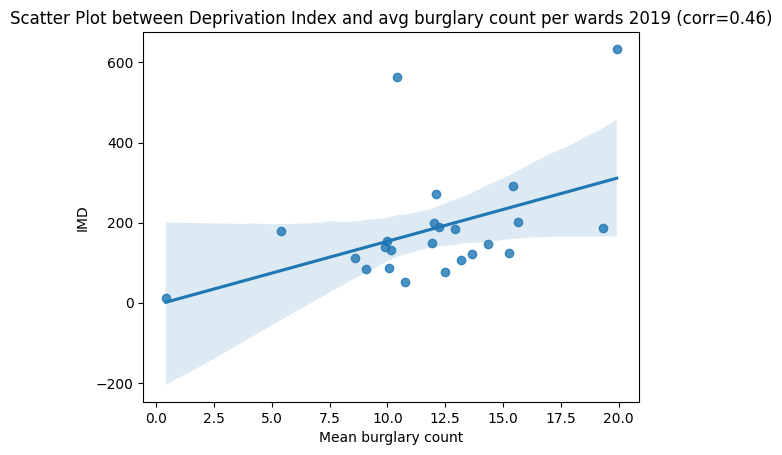

In [16]:
# Plot 
import matplotlib.pyplot as plt 
import seaborn as sns 

# plt.scatter(x=mean_2019, y=imd_df['Value'])
# plt.title('Scatter Plot between Deprivation Index and avg crime count per wards (2019)')
# plt.xlabel('Mean burglary count')
# plt.ylabel('IMD')
ax = sns.regplot(x=mean_2019, y=imd_df['Value'])
ax.set(
    title='Scatter Plot between Deprivation Index and avg burglary count per wards 2019 (corr=0.46)',
    xlabel='Mean burglary count',
    ylabel='IMD',
);
ax.get_figure().savefig('corr.jpg', bbox_inches='tight')


### 6. Area

In [17]:
# Read-in:
area_df = pd.read_csv('data/LSOAs/Lower_Layer_Super_Output_Area_(2021)_EW_BFE.csv')
area_df = area_df[['LSOA21CD', 'SHAPE_Area']].copy()
area_df.rename(columns={'LSOA21CD' : 'LSOA code'}, inplace=True)
area_df = mapping_wards(area_df)
area_df = area_df[area_df['WD22NM'].apply(lambda row: row in pop_df.Ward.values)] # Take only Barnet's
area_df = area_df[['WD22NM', 'SHAPE_Area']].groupby('WD22NM').sum().reset_index()
area_df = area_df.rename(columns={'WD22NM' : 'Ward'})
area_df;

In [18]:
area_df.head()

,Ward,SHAPE_Area
0,Barnet Vale,3.534928e+06
1,Brunswick Park,3.173690e+06
2,Burnt Oak,2.758751e+06
3,Childs Hill,2.875035e+06
4,Colindale North,9.387545e+05


### 7. Combine

In [19]:
# Combine 
df = pd.concat(
    [pop_df, crime_df, cctv_df, imd_df, area_df],
    axis=1
)
df.drop(columns=['Ward'], inplace=True)
df['Ward'] = pop_df.Ward
df['density'] = df.Value / df.SHAPE_Area

In [20]:
# Proportion 
col = ['pop_2012', 'predicted_crime', 'Camera', 'Value', 'SHAPE_Area', 
       'density']
for col_name in col:
    df[col_name] = df[col_name] / sum(df[col_name])
df.columns = ['pop_2012', 'predicted_crime', 'camera', 'imd_value', 'area', 'ward' ,'density']    

In [21]:
# Write to csv
df.reset_index(drop=True).to_csv('data/property.csv', index=False)

### 7. Test run 

In [25]:
df

,pop_2012,predicted_crime,camera,imd_value,area,ward,density
0,0.040710,0.023685,0.044156,0.027964,0.033664,Barnet Vale,0.027262
1,0.046425,0.052203,0.057143,0.029974,0.030224,Brunswick Park,0.032548
2,0.060563,0.035664,0.077922,0.066496,0.026272,Burnt Oak,0.083068
3,0.047806,0.105859,0.041558,0.042253,0.027380,Childs Hill,0.050648
4,0.033979,0.024773,0.025974,0.040719,0.008940,Colindale North,0.149483
5,0.004252,0.002479,0.046753,0.002904,0.013331,Colindale South,0.007150
6,0.029320,0.059272,0.010390,0.042835,0.019881,Cricklewood,0.070710
7,0.046899,0.024646,0.059740,0.034090,0.035732,East Barnet,0.031311
8,0.042064,0.031536,0.000000,0.035087,0.024036,East Finchley,0.047908
9,0.050474,0.067986,0.062338,0.061872,0.039960,Edgware,0.050815
